**Importing the libraries**

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras import regularizers

**Loading the File**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving compresive_strength_concrete.csv to compresive_strength_concrete.csv


In [3]:
import io
df= pd.read_csv(io.BytesIO(uploaded["compresive_strength_concrete.csv"]))

In [4]:
normalized_data=df.copy()


**Split Traning and Testing data**

In [6]:
normalized_data = normalized_data.sample(frac=1) # Shuffling the data
train_data_full= normalized_data.iloc[:721,:]
test_data_full = normalized_data.iloc[721:, :]
train_data = train_data_full.iloc[:, :-1]
train_labels = train_data_full.iloc[:, -1:]
test_data = test_data_full.iloc[:, :-1]
test_labels = test_data_full.iloc[:, -1:]

In [7]:
print(train_data.shape)
print(test_data.shape)
print(train_labels.shape)
print(test_labels.shape)

(721, 8)
(309, 8)
(721, 1)
(309, 1)


In [8]:
train_data.head(3)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day)
728,331.0,0.0,0.0,192.0,0.0,1025.0,821.0,28
64,266.0,114.0,0.0,228.0,0.0,932.0,670.0,180
266,212.0,0.0,124.8,159.0,7.8,1085.4,799.5,28


In [9]:
train_labels.head(3)

,"Concrete compressive strength(MPa, megapascals)"
728,31.74
64,48.70
266,38.50


In [10]:
test_data.head(3)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day)
763,385.0,0.0,0.0,186.0,0.0,966.0,763.0,1
518,202.0,11.0,141.0,206.0,1.7,942.0,801.0,56
622,307.0,0.0,0.0,193.0,0.0,968.0,812.0,365


In [11]:
test_labels.head(3)

,"Concrete compressive strength(MPa, megapascals)"
763,6.27
518,23.25
622,36.15


In [12]:
train_labels=np.asarray(train_labels).astype(dtype="float64")
test_labels=np.asarray(test_labels).astype(dtype="float64")

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data= (train_data-mean)/std
test_data = (test_data-mean)/std


**Building the Network**

In [13]:
model = models.Sequential()
model.add(layers.Dense(96, kernel_regularizer=regularizers.l1(l1=.001), activation = "relu", input_shape=(train_data.shape[1],)))
model.add(layers.Dense(10, kernel_regularizer=regularizers.l1(l1=.001),activation="relu"))
model.add(layers.Dense(8, kernel_regularizer=regularizers.l1(l1=.001),activation="relu"))
model.add(layers.Dense(6, kernel_regularizer=regularizers.l1(l1=.001),activation="relu"))
model.add(layers.Dense(1))
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

**Compiling the Netwrok**

In [14]:
history=model.fit(train_data, train_labels, epochs=100 , validation_split=.2)


Epoch 1/100
18/18 [==============================] - 1s 18ms/step - loss: 1555.4486 - mae: 35.7512 - val_loss: 1291.5223 - val_mae: 32.4001
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 1473.7741 - mae: 34.5743 - val_loss: 1138.5317 - val_mae: 30.0982
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 1231.4600 - mae: 31.1821 - val_loss: 945.2589 - val_mae: 26.9479
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 1102.2612 - mae: 29.0797 - val_loss: 724.5049 - val_mae: 22.9041
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 827.2644 - mae: 24.7568 - val_loss: 486.2749 - val_mae: 17.9689
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 532.5776 - mae: 18.9872 - val_loss: 294.1311 - val_mae: 13.3773
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 311.4528 - mae: 13.8822 - val_loss: 205.5428 - val_mae: 11.1198
Epoch 8/100
18/18 [===============

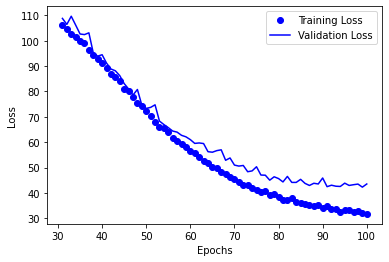

In [15]:
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1, len(loss)+1)
plt.plot(epochs[30:], loss[30:], "bo", label="Training Loss")
plt.plot(epochs[30:], val_loss[30:], "b", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

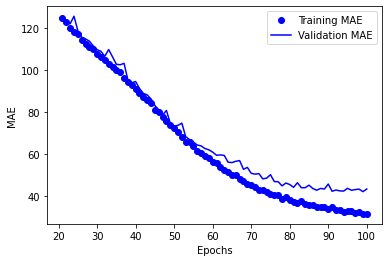

In [16]:
mae=history.history["mae"]
val_mae=history.history["val_mae"]
epochs=range(1, len(mae)+1)
plt.plot(epochs[20:], loss[20:], "bo", label="Training MAE")
plt.plot(epochs[20:], val_loss[20:], "b", label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**Building The final Network**

In [17]:
model = models.Sequential()
model.add(layers.Dense(96, kernel_regularizer=regularizers.l1(l1=.001), activation = "relu", input_shape=(train_data.shape[1],)))
model.add(layers.Dense(10, kernel_regularizer=regularizers.l1(l1=.001),activation="relu"))
model.add(layers.Dense(8, kernel_regularizer=regularizers.l1(l1=.001),activation="relu"))
model.add(layers.Dense(6, kernel_regularizer=regularizers.l1(l1=.001),activation="relu"))
model.add(layers.Dense(1))
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

**Compiling the Final Netwrok**

In [18]:
model.fit(train_data, train_labels, epochs=100)

Epoch 1/100
23/23 [==============================] - 1s 1ms/step - loss: 1541.3548 - mae: 35.3769
Epoch 2/100
23/23 [==============================] - 0s 1ms/step - loss: 1397.4849 - mae: 33.5571
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 1129.5216 - mae: 29.5651
Epoch 4/100
23/23 [==============================] - 0s 2ms/step - loss: 850.9812 - mae: 25.1422
Epoch 5/100
23/23 [==============================] - 0s 1ms/step - loss: 541.8084 - mae: 19.0392
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 317.0070 - mae: 14.1110
Epoch 7/100
23/23 [==============================] - 0s 2ms/step - loss: 226.8770 - mae: 12.0007
Epoch 8/100
23/23 [==============================] - 0s 1ms/step - loss: 184.8027 - mae: 10.8166
Epoch 9/100
23/23 [==============================] - 0s 2ms/step - loss: 202.8304 - mae: 11.5216
Epoch 10/100
23/23 [==============================] - 0s 1ms/step - loss: 190.9159 - mae: 11.1811
Epoch 11/100
23/23 [======

**Evaluating the Network**

In [19]:
test_mse_scoe, test_mae_score=model.evaluate(test_data, test_labels)

10/10 [==============================] - 0s 2ms/step - loss: 39.5266 - mae: 4.7567


In [20]:
test_mae_score

4.756676197052002

**Predicting the values**

In [21]:
denormalized = test_labels

In [22]:
prediction=model.predict(test_data)

In [23]:
pred_norm=prediction

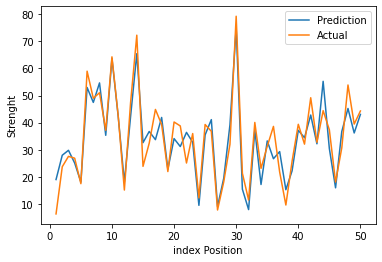

In [24]:
plt.plot(range(1, len(pred_norm[:300:6])+1), pred_norm[:300:6], label="Prediction")
plt.plot(range(1, len(pred_norm[:300:6])+1), denormalized[:300:6], label="Actual")
plt.xlabel("index Position")
plt.ylabel("Strenght")
plt.legend()
plt.show()
